## Exercici 1
Realitza web scraping d'una pàgina de la borsa de Madrid (https://www.bolsamadrid.es) utilitzant BeautifulSoup i Selenium.

**BeautifulSoup**

In [32]:
import requests

URL = "https://www.bolsamadrid.es/esp/aspx/Mercados/Precios.aspx?indice=ESI100000000&punto=indice"
page = requests.get(URL)

print(page.text)


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml">
<head data-idioma="esp" data-hora-act="Fri, 01 Apr 2022 21:25:14 GMT" data-app-path="/" data-bolsa="BMadrid" data-analytics-id="UA-35966870-2"><meta http-equiv="X-UA-Compatible" content="IE=11" /><meta http-equiv="Content-Type" content="text/html; charset=UTF-8" /><meta id="ctl00_copyright" name="copyright" content="Copyright © BME 2022" /><title>
	Bolsa de Madrid - Precios Sesión
</title><link id="ctl00_RSSLink1" rel="alternate" type="application/rss+xml" href="/esp/aspx/RSS/RSS.ashx?feed=Todo" title="Bolsa de Madrid: Todos los contenidos agregados" /><link id="ctl00_RSSLink2" rel="alternate" type="application/rss+xml" href="/esp/aspx/RSS/RSS.ashx?feed=NotasPrensa" title="Bolsa de Madrid: Notas de Prensa" /><link id="ctl00_RSSLink3" rel="alternate" type="application/rss+xml" href="/esp/aspx/RSS/RSS.ashx?feed=Regulacion" 

In [33]:
import requests
from bs4 import BeautifulSoup

URL = "https://www.bolsamadrid.es/esp/aspx/Mercados/Precios.aspx?indice=ESI100000000&punto=indice"
page = requests.get(URL)

soup = BeautifulSoup(page.content, "html.parser")

In [34]:
empresas = soup.find_all("td", class_="DifFlBj")
difs = soup.find_all("td", class_="DifClBj")

empresas_bj = []
for empresa in empresas:
    empresas_bj.append(empresa.text.strip())

print(len(empresas_bj), empresas_bj)

difs_bj = []
for dif in difs:
    difs_bj.append(dif.text.strip())
    
print(len(difs_bj), difs_bj)

14 ['AENA', 'ALMIRALL', 'AMADEUS', 'CIE AUTOMOT.', 'ENDESA', 'FLUIDRA', 'GRIFOLS CL.A', 'IAG', 'IBERDROLA', 'INDRA A', 'MELIA HOTELS', 'NATURGY', 'ROVI', 'SIEMENS GAME']
15 ['-2,41', '-2,58', '-0,35', '-1,22', '-0,77', '-0,76', '-4,18', '-0,09', '-0,03', '-0,06', '-5,94', '-1,12', '-1,10', '-2,01', '-0,19']


In [35]:
empresas = soup.find_all("td", class_="DifFlSb")
difs = soup.find_all("td", class_="DifClSb")

empresas_sb = []
for empresa in empresas:
    empresas_sb.append(empresa.text.strip())

print(len(empresas_sb), empresas_sb)

difs_sb = []
for dif in difs:
    difs_sb.append(dif.text.strip())
    
print(len(difs_sb), difs_sb)

22 ['IBEX 35®', 'ACCIONA', 'ACERINOX', 'ACS', 'ARCELORMIT.', 'B.SANTANDER', 'BA.SABADELL', 'BANKINTER', 'BBVA', 'CAIXABANK', 'CELLNEX', 'ENAGAS', 'FERROVIAL', 'INDITEX', 'INM.COLONIAL', 'MAPFRE', 'MERLIN', 'PHARMA MAR', 'R.E.C.', 'REPSOL', 'SOLARIA', 'TELEFONICA']
22 ['0,69', '1,33', '1,65', '0,37', '1,60', '2,61', '0,78', '1,16', '1,54', '3,15', '0,71', '0,30', '1,04', '1,67', '0,24', '0,37', '0,33', '5,00', '0,99', '0,18', '1,66', '0,65']


In [36]:
# Averiguar si el IBEX ha subido o ha bajado
if "IBEX 35®" in empresas_sb:
    print(empresas_sb)
    index = empresas_sb.index("IBEX 35®")
    empresas_sb.remove("IBEX 35®")
    print(empresas_sb)
elif "IBEX 35®" in empresas_bj:
    print(empresas_bj)
    index = empresas_bj.index("IBEX 35®")
    empresas_bj.remove("IBEX 35®")
    print(empresas_bj)

['IBEX 35®', 'ACCIONA', 'ACERINOX', 'ACS', 'ARCELORMIT.', 'B.SANTANDER', 'BA.SABADELL', 'BANKINTER', 'BBVA', 'CAIXABANK', 'CELLNEX', 'ENAGAS', 'FERROVIAL', 'INDITEX', 'INM.COLONIAL', 'MAPFRE', 'MERLIN', 'PHARMA MAR', 'R.E.C.', 'REPSOL', 'SOLARIA', 'TELEFONICA']
['ACCIONA', 'ACERINOX', 'ACS', 'ARCELORMIT.', 'B.SANTANDER', 'BA.SABADELL', 'BANKINTER', 'BBVA', 'CAIXABANK', 'CELLNEX', 'ENAGAS', 'FERROVIAL', 'INDITEX', 'INM.COLONIAL', 'MAPFRE', 'MERLIN', 'PHARMA MAR', 'R.E.C.', 'REPSOL', 'SOLARIA', 'TELEFONICA']


In [37]:
print(len(empresas_sb), len(difs_sb))

while len(empresas_sb) < len(difs_sb):
    difs_sb.remove(f"{difs_sb[0]}")
    
print(len(empresas_sb), len(difs_sb))

21 22
21 21


In [38]:
print(len(empresas_bj), len(difs_bj))

while len(empresas_bj) < len(difs_bj):
    index= difs_bj[0]
    difs_bj.remove(f"{difs_bj[0]}")
    
print(len(empresas_bj), len(difs_bj))

14 15
14 14


In [39]:
import pandas as pd

cambios_ibex = pd.DataFrame()

cambios_ibex["Empresa"] = empresas_bj + empresas_sb
cambios_ibex["Dif"] = difs_bj + difs_sb
cambios_ibex = cambios_ibex.sort_values(by=['Empresa'])

display(cambios_ibex)

,Empresa,Dif
14,ACCIONA,"1,33"
15,ACERINOX,"1,65"
16,ACS,"0,37"
0,AENA,"-2,58"
1,ALMIRALL,"-0,35"
2,AMADEUS,"-1,22"
17,ARCELORMIT.,"1,60"
18,B.SANTANDER,"2,61"
19,BA.SABADELL,"0,78"
20,BANKINTER,"1,16"


In [40]:
cambios_ibex['Dif'] = cambios_ibex['Dif'].str.replace(',','.')
cambios_ibex['Dif'] = pd.to_numeric(cambios_ibex['Dif'])
cambios_ibex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 14 to 34
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Empresa  35 non-null     object 
 1   Dif      35 non-null     float64
dtypes: float64(1), object(1)
memory usage: 840.0+ bytes


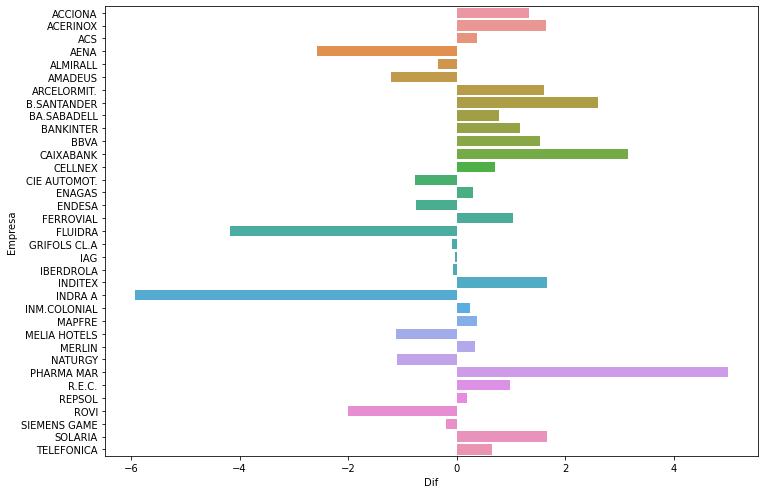

In [41]:
from matplotlib import pyplot as plt
import seaborn

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
seaborn.barplot(x="Dif", y="Empresa", data=cambios_ibex)
plt.show()

**Selenium**

In [85]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from collections import namedtuple
from os.path import isfile
from threading import Thread
import csv
from time import sleep, ctime


BOLSA_PRECIOSIBEX ='https://www.bolsamadrid.es/esp/aspx/Mercados/Precios.aspx?indice=ESI100000000&punto=indice'
precios_sesion = namedtuple('precios_sesion', ['company', 'dif', 'timestamp'])


class PreciosIbex():
    def __init__(self):

        options = webdriver.ChromeOptions()
        options.add_argument("--start-maximized")
        options.add_argument('--log-level=3')
        options.add_argument('--headless')

        self.driver = webdriver.Chrome(
            executable_path="chromedriver",
            options=options
        )
        self.driver.get(BOLSA_PRECIOSIBEX)

        self.empresas_sb = []
        self.empresas_bj = []
        self.difs_sb = []
        self.difs_bj = []
        
        self.empresas_all = []
        self.difs_all = []
        self.horas = []
        
        self.datos()
                
        self.hora = ctime()
        

        self.database_path= f"precios_IBEX35_{self.hora}.csv"
        self.database = []
        
        if isfile(self.database_path):
            with open(self.database_path, newline='') as dbfile:
                dbreader = csv.reader(dbfile)
                next(dbreader)
        
        self.thread = Thread(target=self.maintain)
        self.thread.daemon = True 
        self.thread.start()
        
    
    def maintain(self):
        while True:
            self.update_db()
            sleep(20)
    
    
    def save_db(self):
        with open(self.database_path,'w', newline='') as dbfile:
            dbwriter = csv.writer(dbfile)
            dbwriter.writerow(list(precios_sesion._fields))
            for entry in self.database:
                dbwriter.writerow(list(entry))
                

    def update_db(self):
        check = ((
            (len(self.empresas_sb) > 0 and len(self.difs_sb) > 0) 
            or 
            (len(self.empresas_bj) > 0 and len(self.difs_bj) > 0)
        ))

        if check:
            print(len(self.empresas_all), len(self.difs_all), len(self.horas))
            for i in range(len(self.empresas_all)):
                self.database.append([self.empresas_all[i], self.difs_all[i], self.horas[i]])
                self.save_db()

        
    def datos(self):
        '''
        Recabar información de la página relativa a cambios en el IBEX
        '''

        # Sleep para dar tiempo a la página para cargar
        sleep(1)

        empresas_sb = self.driver.find_elements(By.CLASS_NAME,'DifFlSb')
        empresas_bj = self.driver.find_elements(By.CLASS_NAME,'DifFlBj')
        difs_sb = self.driver.find_elements(By.CLASS_NAME,'DifClSb')
        difs_bj = self.driver.find_elements(By.CLASS_NAME,'DifClBj')
        horas = self.driver.find_elements(By.CLASS_NAME,'Ult')
        
        self.empresas_sb = [i.text for i in empresas_sb]
        self.empresas_bj = [i.text for i in empresas_bj]
        self.difs_sb = [i.text for i in difs_sb]
        self.difs_bj = [i.text for i in difs_bj]
        self.horas = [i.text for i in horas]
        
        self.eliminar_info_gral_IBEX()
        
        self.convertir_float()
        self.crear_tabla()
    
    
    def eliminar_info_gral_IBEX(self):
              
        if "IBEX 35®" in self.empresas_sb:
            self.empresas_sb.remove("IBEX 35®")
        elif "IBEX 35®" in self.empresas_bj:
            self.empresas_bj.remove("IBEX 35®")

        while len(self.empresas_sb) < len(self.difs_sb):
            self.difs_sb.remove(f"{self.difs_sb[0]}")
        while len(self.empresas_bj) < len(self.difs_bj):
            self.difs_bj.remove(f"{self.difs_bj[0]}")
        
        self.empresas_all = self.empresas_sb + self.empresas_bj        
        self.difs_all = self.difs_sb + self.difs_bj
        
        while len(self.difs_all) < len(self.horas):
            self.horas.remove(f"{self.horas[0]}")
        
        
    def convertir_float(self):
        floated_difs = []
        for dif in self.difs_all:
            dif = dif.replace(",", ".")
            dif = float(dif)
            floated_difs.append(dif)
        self.difs_all = floated_difs
        
        
    def crear_tabla(self):
        cambios_ibex = pd.DataFrame()
        cambios_ibex["Empresa"] = self.empresas_bj + self.empresas_sb
        cambios_ibex["Dif"] = self.difs_bj + self.difs_sb
        cambios_ibex['Dif'] = cambios_ibex['Dif'].str.replace(',','.')
        cambios_ibex['Dif'] = pd.to_numeric(cambios_ibex['Dif'])
        cambios_ibex['Hora'] = self.horas
        
        
    def ver_grafico(self):
        self.crear_tabla()
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        seaborn.barplot(x="Dif", y="Empresa", data=cambios_ibex)
        
    
    def ver_datos(self):
        self.crear_tabla()
        display(cambios_ibex)
    

In [86]:
precios_ibex = PreciosIbex()

35 35 35
35 35 35
35 35 35
35 35 35
35 35 35
35 35 35
35 35 35
35 35 35
35 35 35
35 35 35
35 35 35
35 35 35
35 35 35
35 35 35
35 35 35
35 35 35
35 35 35


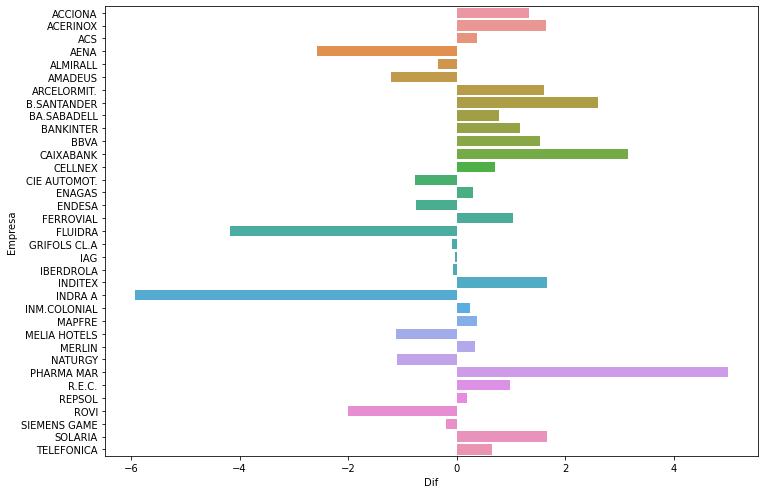

In [50]:
precios_ibex.ver_grafico()

In [51]:
precios_ibex.ver_datos()

,Empresa,Dif
14,ACCIONA,1.33
15,ACERINOX,1.65
16,ACS,0.37
0,AENA,-2.58
1,ALMIRALL,-0.35
2,AMADEUS,-1.22
17,ARCELORMIT.,1.60
18,B.SANTANDER,2.61
19,BA.SABADELL,0.78
20,BANKINTER,1.16
